In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('C:/Users/dlaqh/OneDrive/FILE/DataCoSupplyChainDataset.csv',header= 0, encoding = 'unicode_escape')
pd.set_option('display.max_columns',None)
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,RajastÃ¡n,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,RajastÃ¡n,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [8]:

rfm_df = data[['Customer Id', 'order date (DateOrders)', 'Sales per customer']]
rfm_df = rfm_df.rename(columns={'Customer Id': 'CustomerID', 'order date (DateOrders)': 'OrderDate', 'Sales per customer': 'Sales'})

# 'OrderDate' 컬럼을 날짜 형식으로 변환
rfm_df['OrderDate'] = pd.to_datetime(rfm_df['OrderDate'], errors='coerce')

# 기준일을 데이터의 마지막 구매일 이후로 설정
analysis_date = rfm_df['OrderDate'].max() + pd.Timedelta(days=1)  # 하루를 추가한 날짜로 설정



# RFM 분석을 위한 Recency, Frequency, Monetary 값 계산
rfm = rfm_df.groupby('CustomerID').agg(
    Recency=('OrderDate', lambda x: (analysis_date - x.max()).days),  # Recency: 가장 최근 구매일로부터의 일수
    Frequency=('OrderDate', 'count'),                                # Frequency: 총 구매 횟수
    Monetary=('Sales', 'sum')                                        # Monetary: 총 구매 금액
).reset_index()

# Recency, Frequency, Monetary 값을 적절한 구간으로 나누기 위해 cut 함수를 사용합니다.
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.cut(rfm['Monetary'], bins=5, labels=[1, 2, 3, 4, 5])

# 최종 RFM 점수를 계산
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# 고객 세그먼트 분류 (예: VIP, 일반 고객 등)
def segment_customer(df):
    if df['RFM_Score'] >= '555':
        return 'VIP'
    elif df['RFM_Score'] >= '355':
        return 'Loyal'
    elif df['RFM_Score'] >= '155':
        return 'Potential'
    else:
        return 'Regular'

rfm['Customer Segment'] = rfm.apply(segment_customer, axis=1)

# RFM 분석 결과를 고객 세그먼트별로 집계하여 표시
rfm_summary = rfm.groupby('Customer Segment').agg(
    Customer_Count=('CustomerID', 'nunique'),
    Average_Recency=('Recency', 'mean'),
    Average_Frequency=('Frequency', 'mean'),
    Average_Monetary=('Monetary', 'mean')
).reset_index()

# RFM 분석 요약 결과 출력
print("RFM Analysis Summary:")
print(rfm_summary)

RFM Analysis Summary:
  Customer Segment  Customer_Count  Average_Recency  Average_Frequency  \
0            Loyal           18063       161.535127           8.610253   
1        Potential            2355       604.671338          10.031423   
2          Regular             225       989.982222           4.400000   
3              VIP               9       153.000000          42.000000   

   Average_Monetary  
0       1583.694202  
1       1783.308980  
2        774.416720  
3       8244.177873  


In [3]:
import matplotlib.pyplot as plt

In [18]:
# 'Order Id'를 사용하여 지역별 고객 분포 및 특성 분석을 진행합니다.
# 'Order Region' 컬럼에서 결측치를 제거하고 분석에 필요한 데이터 추출
region_analysis = data.dropna(subset=['Order Region'])

# 지역별로 고객 수, 총 판매액, 구매 횟수 집계
region_summary = region_analysis.groupby('Order Region').agg(
    Total_Customers=('Customer Id', 'nunique'),  # 고유 고객 수
    Total_Sales=('Sales per customer', 'sum'),     # 총 판매액
    Purchase_Frequency=('Order Id', 'count')       # 총 구매 횟수
).reset_index()

# 지역별 분석 결과 출력
print("Order Region Analysis Summary:")
print(region_summary)

Order Region Analysis Summary:
       Order Region  Total_Customers   Total_Sales  Purchase_Frequency
0            Canada              303  1.682574e+05                 959
1         Caribbean             2506  1.481669e+06                8318
2    Central Africa              540  2.929126e+05                1677
3   Central America             6564  5.093850e+06               28341
4      Central Asia              181  9.795369e+04                 553
5       East Africa              600  3.380543e+05                1852
6       East of USA             2129  1.231955e+06                6915
7      Eastern Asia             3169  1.334313e+06                7280
8    Eastern Europe             1245  6.963072e+05                3920
9      North Africa             1021  5.722420e+05                3232
10  Northern Europe             3340  1.939362e+06                9792
11          Oceania             4042  1.809997e+06               10148
12    South America             4131  2.660244

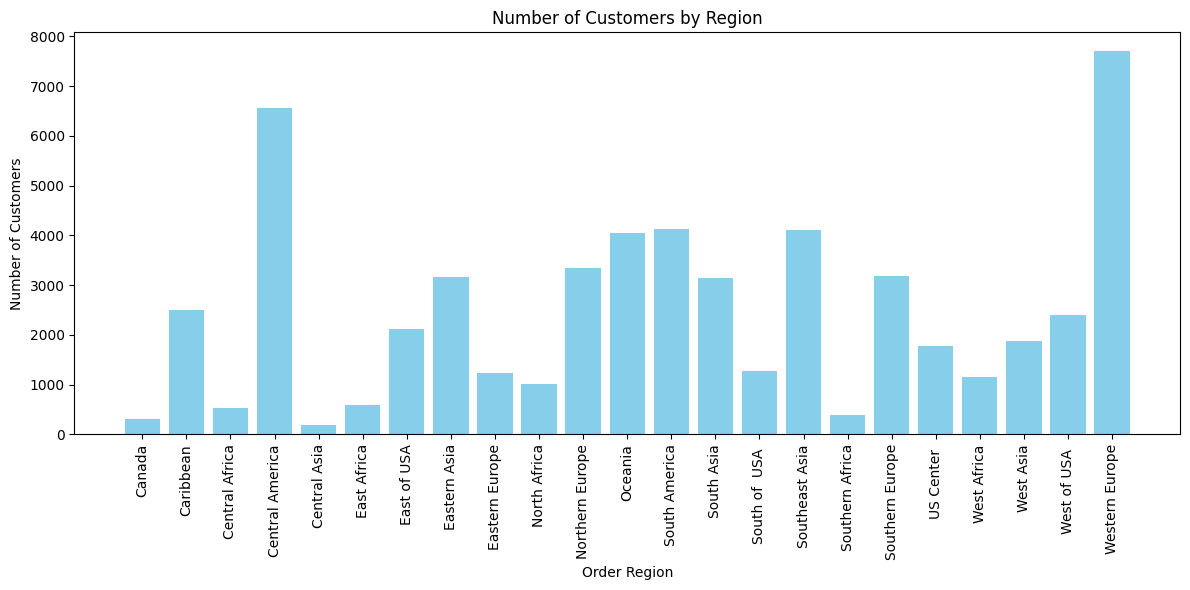

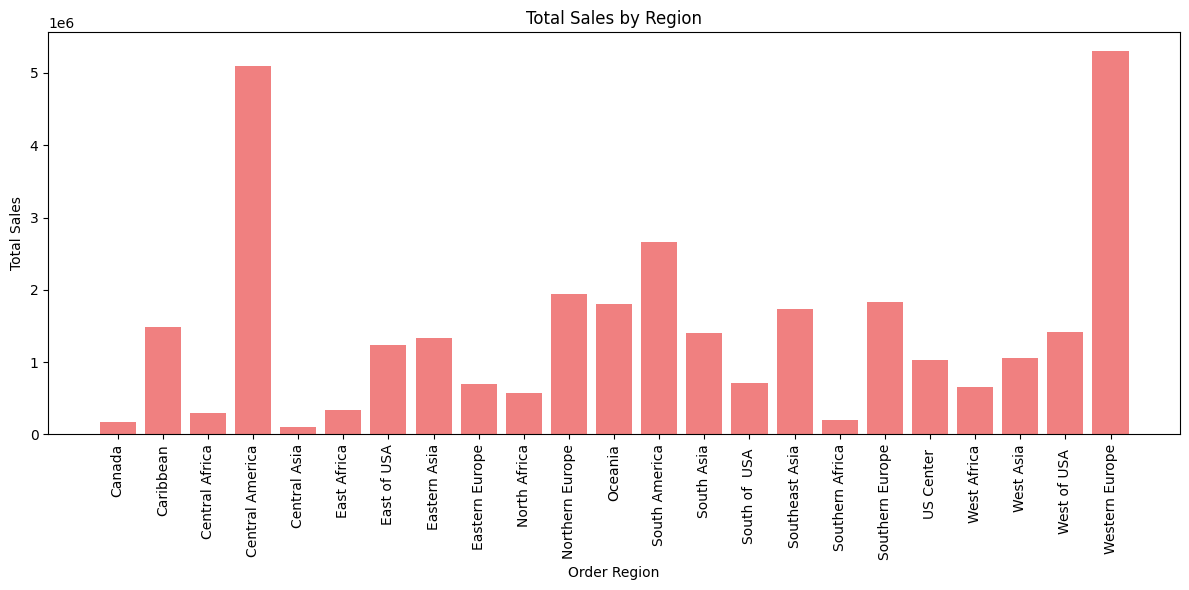

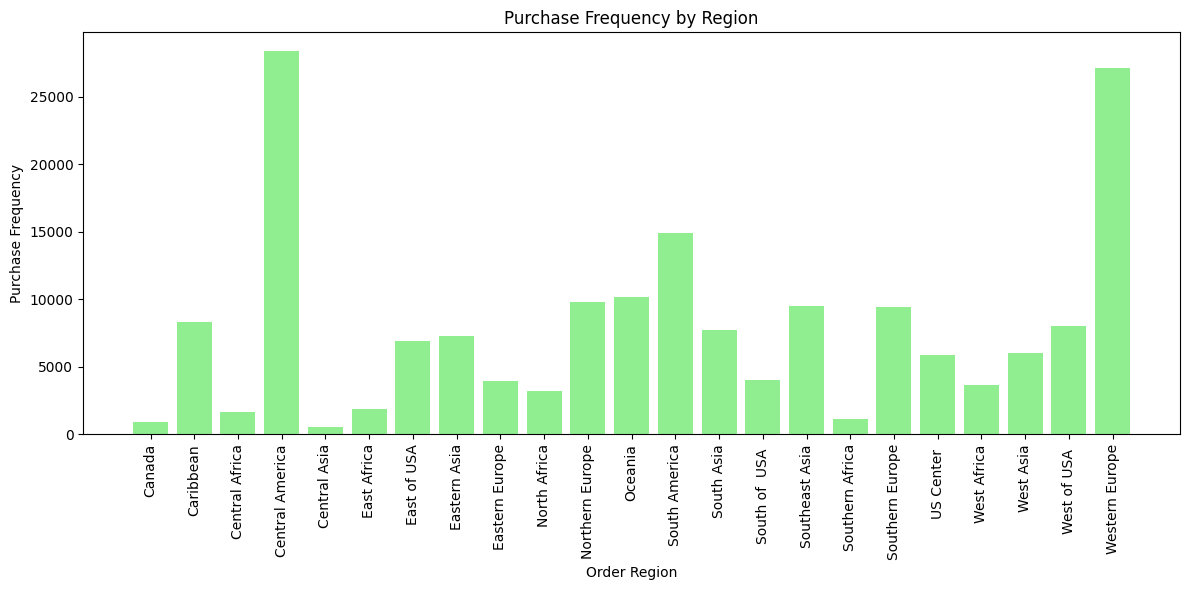

In [19]:
# 시각화: 지역별 고객 수
plt.figure(figsize=(12, 6))
plt.bar(region_summary['Order Region'], region_summary['Total_Customers'], color='skyblue')
plt.xlabel('Order Region')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Region')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 시각화: 지역별 총 판매액
plt.figure(figsize=(12, 6))
plt.bar(region_summary['Order Region'], region_summary['Total_Sales'], color='lightcoral')
plt.xlabel('Order Region')
plt.ylabel('Total Sales')
plt.title('Total Sales by Region')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 시각화: 지역별 구매 횟수
plt.figure(figsize=(12, 6))
plt.bar(region_summary['Order Region'], region_summary['Purchase_Frequency'], color='lightgreen')
plt.xlabel('Order Region')
plt.ylabel('Purchase Frequency')
plt.title('Purchase Frequency by Region')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [6]:
# 고객별 구매 횟수 계산
customer_purchase_counts = data.groupby('Customer Id')['Order Id'].nunique().reset_index()
customer_purchase_counts = customer_purchase_counts.rename(columns={'Order Id': 'Purchase_Count'})

# 재구매 고객 수 (2회 이상 구매한 고객)
repeat_customers = customer_purchase_counts[customer_purchase_counts['Purchase_Count'] > 1].shape[0]

# 전체 고객 수
total_customers = customer_purchase_counts.shape[0]

# 재구매율 계산
repeat_purchase_rate = (repeat_customers / total_customers) * 100

print(f"재구매율: {repeat_purchase_rate:.2f}%")


재구매율: 56.98%


In [7]:
import pandas as pd
from datetime import datetime, timedelta

# 데이터셋에서 고객 이메일과 주문 날짜를 가져옵니다.
customer_orders = data[['Customer Id', 'order date (DateOrders)']]
customer_orders['order date (DateOrders)'] = pd.to_datetime(customer_orders['order date (DateOrders)'], errors='coerce')

# 고객별로 마지막 구매 날짜 계산
last_purchase = customer_orders.groupby('Customer Id')['order date (DateOrders)'].max().reset_index()
last_purchase = last_purchase.rename(columns={'order date (DateOrders)': 'Last_Purchase_Date'})

# 'shipping date (DateOrders)' 컬럼을 날짜 형식으로 변환합니다.
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'], errors='coerce')

# 데이터셋에서 가장 최근 및 가장 오래된 구매일을 확인합니다.
date_range = data['order date (DateOrders)'].agg(['min', 'max'])

print("데이터 기간:")
print(date_range)

# 분석 기준일을 데이터의 마지막 날짜로 설정
analysis_date = data['order date (DateOrders)'].max()

# 고객별로 마지막 구매 날짜 계산
customer_orders = data[['Customer Id', 'order date (DateOrders)']]
last_purchase = customer_orders.groupby('Customer Id')['order date (DateOrders)'].max().reset_index()
last_purchase = last_purchase.rename(columns={'order date (DateOrders)': 'Last_Purchase_Date'})

# 기준일과 비교하여 이탈 기간 계산 (예: 180일 이상)
last_purchase['Days_Since_Last_Purchase'] = (analysis_date - last_purchase['Last_Purchase_Date']).dt.days

# 이탈 고객 정의 (180일 이상 구매가 없었던 고객을 이탈 고객으로 정의)
last_purchase['Churned'] = last_purchase['Days_Since_Last_Purchase'] > 180

# 이탈 고객 수 계산
churned_customers = last_purchase[last_purchase['Churned'] == True].shape[0]
total_customers = last_purchase.shape[0]
churn_rate = (churned_customers / total_customers) * 100

print(f"전체 고객 수: {total_customers}")
print(f"이탈 고객 수: {churned_customers}")
print(f"이탈률: {churn_rate:.2f}%")

C:\Users\dlaqh\AppData\Local\Temp\ipykernel_4952\3858657698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_orders['order date (DateOrders)'] = pd.to_datetime(customer_orders['order date (DateOrders)'], errors='coerce')


데이터 기간:
min   2015-01-01 00:00:00
max   2018-01-31 23:38:00
Name: order date (DateOrders), dtype: datetime64[ns]
전체 고객 수: 20652
이탈 고객 수: 9356
이탈률: 45.30%


In [33]:
#고객 주기 분석
# 고객 이메일과 주문 날짜 데이터 추출
customer_orders = data[['Customer Id', 'order date (DateOrders)']]
customer_orders['order date (DateOrders)'] = pd.to_datetime(customer_orders['order date (DateOrders)'], errors='coerce')

# 고객별로 구매 날짜를 정렬
customer_orders = customer_orders.sort_values(by=['Customer Id', 'order date (DateOrders)'])

# 각 고객별 구매 간격 계산
customer_orders['Previous_Purchase_Date'] = customer_orders.groupby('Customer Id')['order date (DateOrders)'].shift(1)
customer_orders['Purchase_Interval'] = (customer_orders['order date (DateOrders)'] - customer_orders['Previous_Purchase_Date']).dt.days

# 각 고객의 평균 구매 주기 계산
average_purchase_cycle = customer_orders.groupby('Customer Id')['Purchase_Interval'].mean().reset_index()
average_purchase_cycle = average_purchase_cycle.rename(columns={'Purchase_Interval': 'Average_Purchase_Cycle'})

# 구매 주기 분석 결과에서 구매 주기가 1일 이상인 고객만 고려하여 상위 5명을 추출합니다.
filtered_cycle_customers = average_purchase_cycle[average_purchase_cycle['Average_Purchase_Cycle'] > 1]

# 전체 고객의 평균 구매 주기
overall_average_cycle = average_purchase_cycle['Average_Purchase_Cycle'].mean()

# 구매 주기가 가장 짧은 상위 5명 고객 ID 추출
shortest_cycle_customers_over_1_day = filtered_cycle_customers.nsmallest(5, 'Average_Purchase_Cycle')

# 구매 주기가 가장 긴 상위 5명 고객 ID 추출
longest_cycle_customers = average_purchase_cycle.nlargest(5, 'Average_Purchase_Cycle')

print("구매 주기가 1일 이상인 고객 중 가장 짧은 상위 5명 고객 ID:")
print(shortest_cycle_customers_over_1_day)

print("\n구매 주기가 가장 긴 상위 5명 고객 ID:")
print(longest_cycle_customers)

print("전체 고객의 평균 구매 주기 (일):", overall_average_cycle)
print(average_purchase_cycle.head())  # 고객별 평균 구매 주기 상위 5명 출력


구매 주기가 1일 이상인 고객 중 가장 짧은 상위 5명 고객 ID:
       Customer Id  Average_Purchase_Cycle
8817          8891                1.222222
11995        12093                1.222222
12249        12352                1.428571
670            678                1.500000
3304          3342                1.500000

구매 주기가 가장 긴 상위 5명 고객 ID:
       Customer Id  Average_Purchase_Cycle
8863          8937                   885.0
10260        10342                   855.0
5267          5315                   810.0
8953          9027                   741.0
4438          4480                   736.0
전체 고객의 평균 구매 주기 (일): 54.02945010941154
   Customer Id  Average_Purchase_Cycle
0            1                     NaN
1            2               85.222222
2            3               32.294118
3            4               47.153846
4            5               22.500000


C:\Users\dlaqh\AppData\Local\Temp\ipykernel_18344\14993250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_orders['order date (DateOrders)'] = pd.to_datetime(customer_orders['order date (DateOrders)'], errors='coerce')


In [35]:
# 제품별 구매 빈도를 계산합니다.
product_purchase_frequency = data.groupby('Product Name').agg(
    Purchase_Frequency=('Order Id', 'count')  # 각 제품의 구매 횟수
).reset_index()

# 구매 빈도가 높은 상위 10개 제품을 확인합니다.
top_10_products_by_frequency = product_purchase_frequency.sort_values(by='Purchase_Frequency', ascending=False).head(10)

print("제품별 구매 빈도 (상위 10개 제품):")
print(top_10_products_by_frequency)

제품별 구매 빈도 (상위 10개 제품):
                                      Product Name  Purchase_Frequency
71                Perfect Fitness Perfect Rip Deck               24515
56         Nike Men's CJ Elite 2 TD Football Cleat               22246
59            Nike Men's Dri-FIT Victory Golf Polo               21035
67                O'Brien Men's Neoprene Life Vest               19298
24       Field & Stream Sportsman 16 Gun Fire Safe               17325
70                     Pelican Sunstream 100 Kayak               15500
21   Diamondback Women's Serene Classic Comfort Bi               13729
61               Nike Men's Free 5.0+ Running Shoe               12169
102  Under Armour Girls' Toddler Spine Surge Runni               10617
25                            Fighting video games                 838


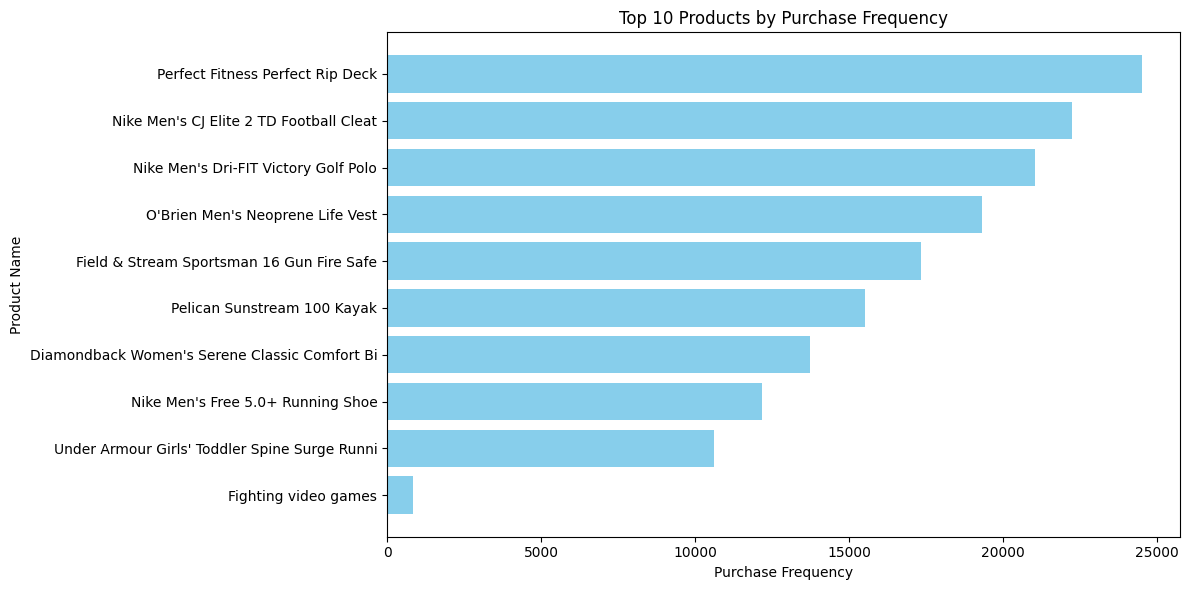

In [36]:
# 제품별 구매 빈도 상위 10개를 시각화합니다.
import matplotlib.pyplot as plt

# 시각화: 상위 10개 제품의 구매 빈도
plt.figure(figsize=(12, 6))
plt.barh(top_10_products_by_frequency['Product Name'], top_10_products_by_frequency['Purchase_Frequency'], color='skyblue')
plt.xlabel('Purchase Frequency')
plt.ylabel('Product Name')
plt.title('Top 10 Products by Purchase Frequency')
plt.gca().invert_yaxis()  # Y축을 역순으로 설정하여 가장 빈도가 높은 제품이 위에 오도록 설정
plt.tight_layout()
plt.show()


고객 유형별 고객 행동 분석 결과:
  Customer Segment   Total_Sales  Average_Purchase  Purchase_Frequency  \
0         Consumer  1.716428e+07        183.567317               93504   
1        Corporate  1.003065e+07        183.077806               54789   
2      Home Office  5.859474e+06        181.824431               32226   

   Total_Customers  
0            10695  
1             6239  
2             3718  


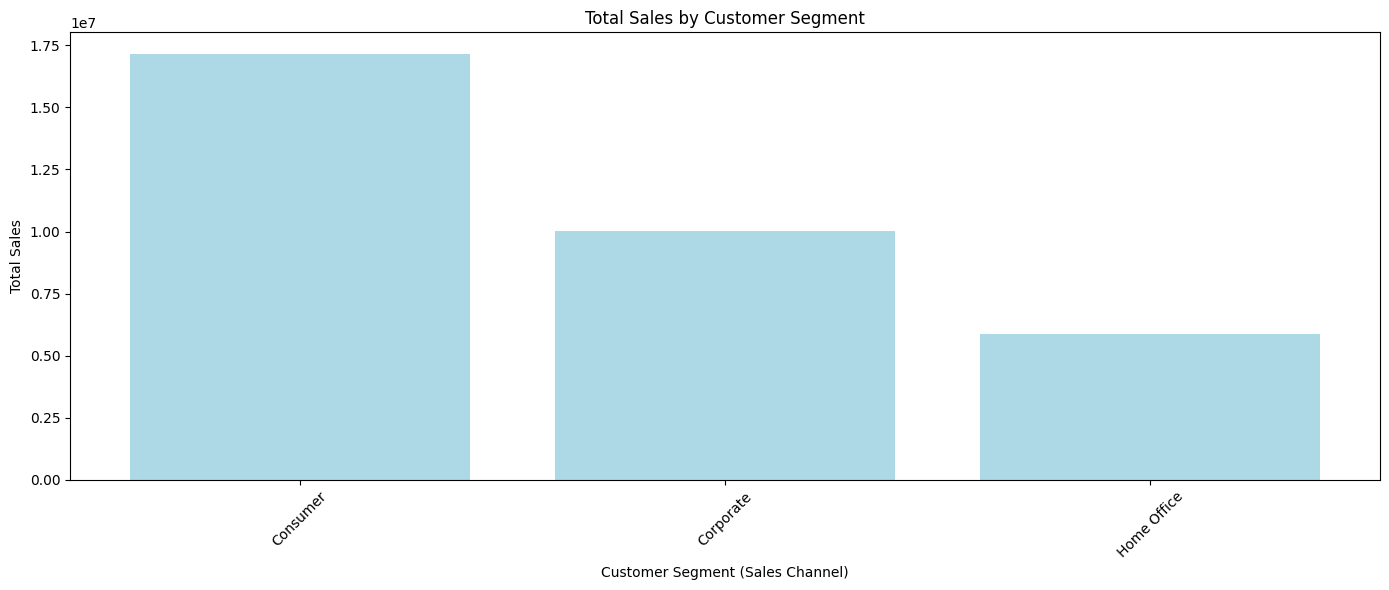

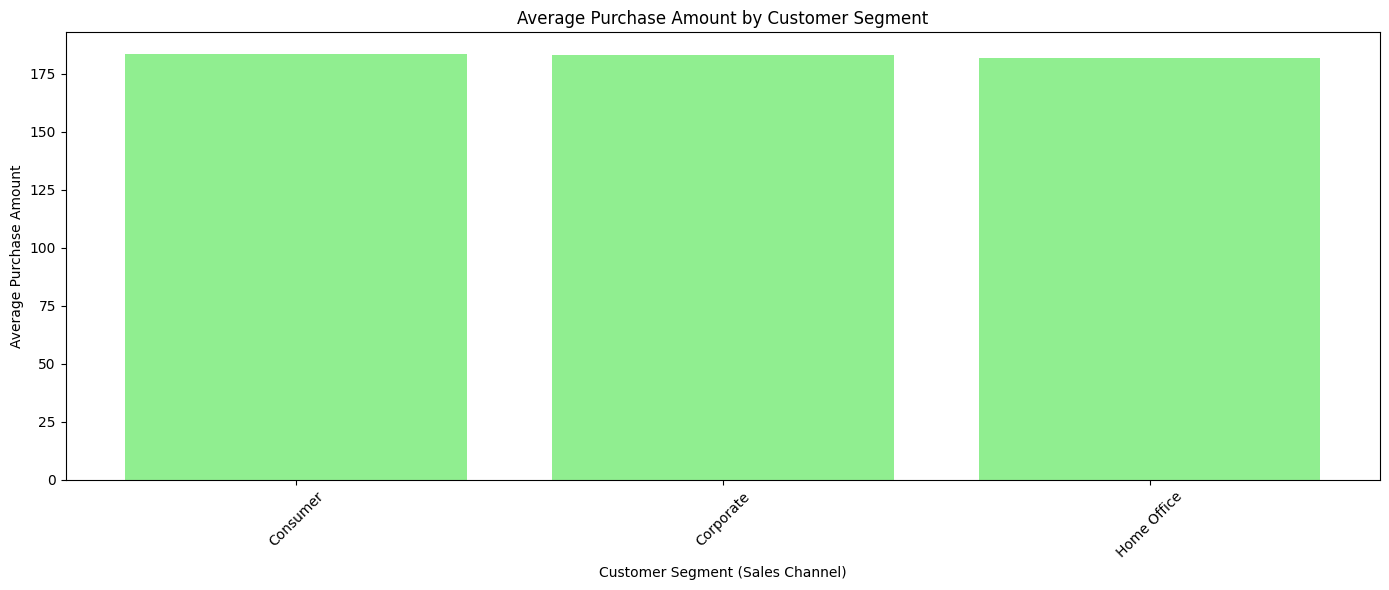

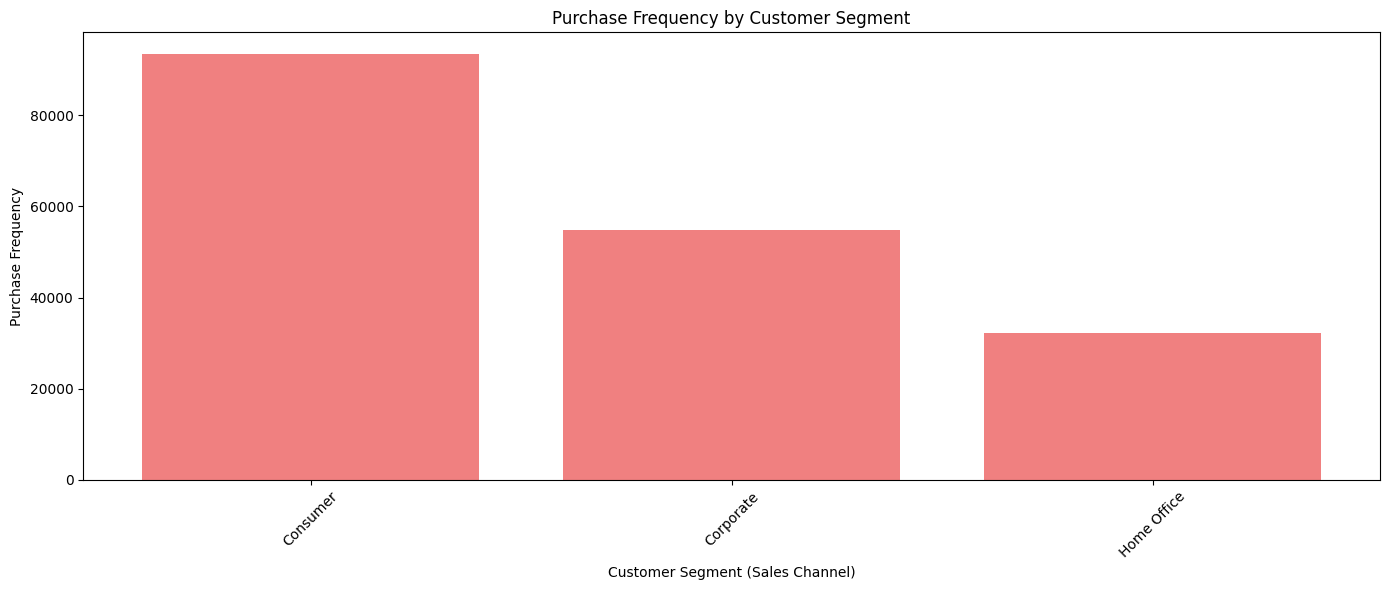

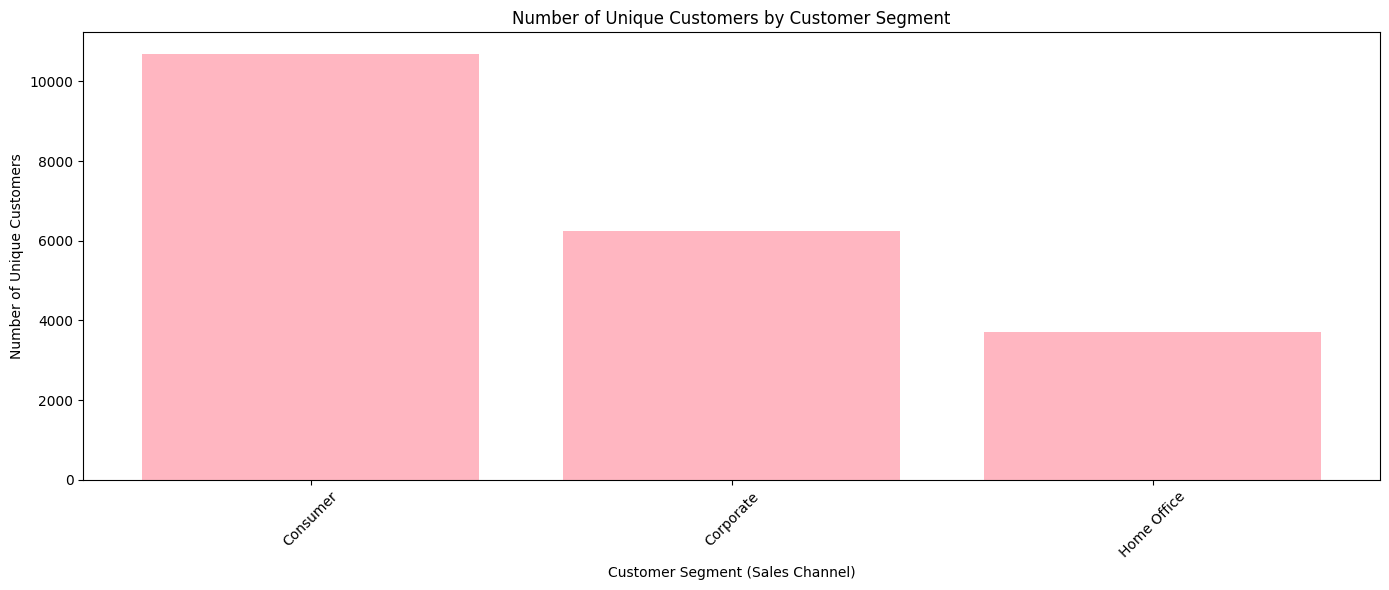

In [37]:
# 'Customer Segment' 컬럼을 기준으로 고객 유형별 고객 분석을 진행합니다.
# 결측치를 제거하고 분석에 필요한 데이터 추출
channel_analysis = data.dropna(subset=['Customer Segment'])

# 고객 유형별  총 매출, 평균 구매 금액, 구매 빈도, 고객 수 집계
channel_behavior_summary = channel_analysis.groupby('Customer Segment').agg(
    Total_Sales=('Sales per customer', 'sum'),       # 총 매출
    Average_Purchase=('Sales per customer', 'mean'), # 평균 구매 금액
    Purchase_Frequency=('Order Id', 'count'),        # 구매 빈도
    Total_Customers=('Customer Id', 'nunique')    # 고유 고객 수
).reset_index()

# 고객 유형별 고객 행동 분석 결과 출력
print("고객 유형별 고객 행동 분석 결과:")
print(channel_behavior_summary.sort_values(by='Total_Sales', ascending=False))

# 시각화: 고객 유형별 총 매출
plt.figure(figsize=(14, 6))
plt.bar(channel_behavior_summary['Customer Segment'], channel_behavior_summary['Total_Sales'], color='lightblue')
plt.xlabel('Customer Segment (Sales Channel)')
plt.ylabel('Total Sales')
plt.title('Total Sales by Customer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 시각화: 고객 유형별 평균 구매 금액
plt.figure(figsize=(14, 6))
plt.bar(channel_behavior_summary['Customer Segment'], channel_behavior_summary['Average_Purchase'], color='lightgreen')
plt.xlabel('Customer Segment (Sales Channel)')
plt.ylabel('Average Purchase Amount')
plt.title('Average Purchase Amount by Customer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 시각화: 고객 유형별 구매 빈도
plt.figure(figsize=(14, 6))
plt.bar(channel_behavior_summary['Customer Segment'], channel_behavior_summary['Purchase_Frequency'], color='lightcoral')
plt.xlabel('Customer Segment (Sales Channel)')
plt.ylabel('Purchase Frequency')
plt.title('Purchase Frequency by Customer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 시각화: 판매 채널별 고객 수
plt.figure(figsize=(14, 6))
plt.bar(channel_behavior_summary['Customer Segment'], channel_behavior_summary['Total_Customers'], color='lightpink')
plt.xlabel('Customer Segment (Sales Channel)')
plt.ylabel('Number of Unique Customers')
plt.title('Number of Unique Customers by Customer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


캠페인 기간과 비캠페인 기간의 매출 비교:
                Campaign   Total_Sales  Average_Sales  Total_Orders  \
0  Before/After Campaign  2.042369e+06     203.666651         10028   
1        During Campaign  3.474237e+07     203.778298        170491   

   Unique_Customers  
0              6822  
1             20180  


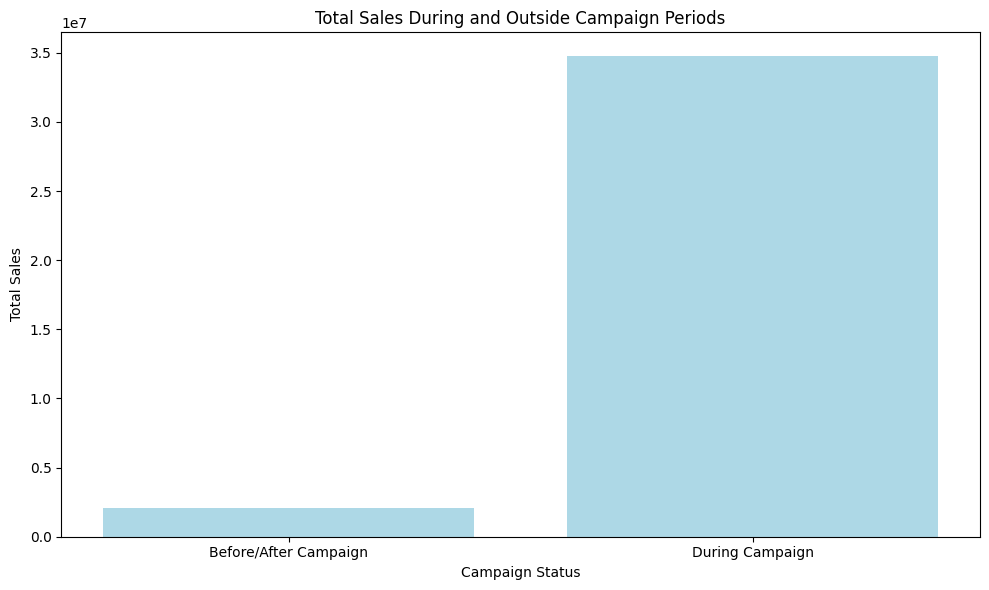

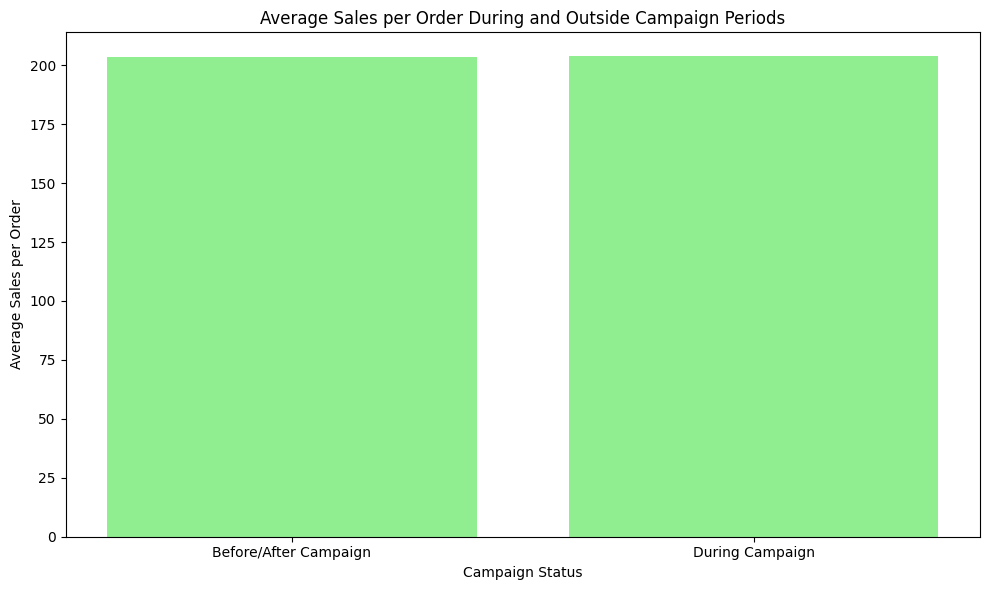

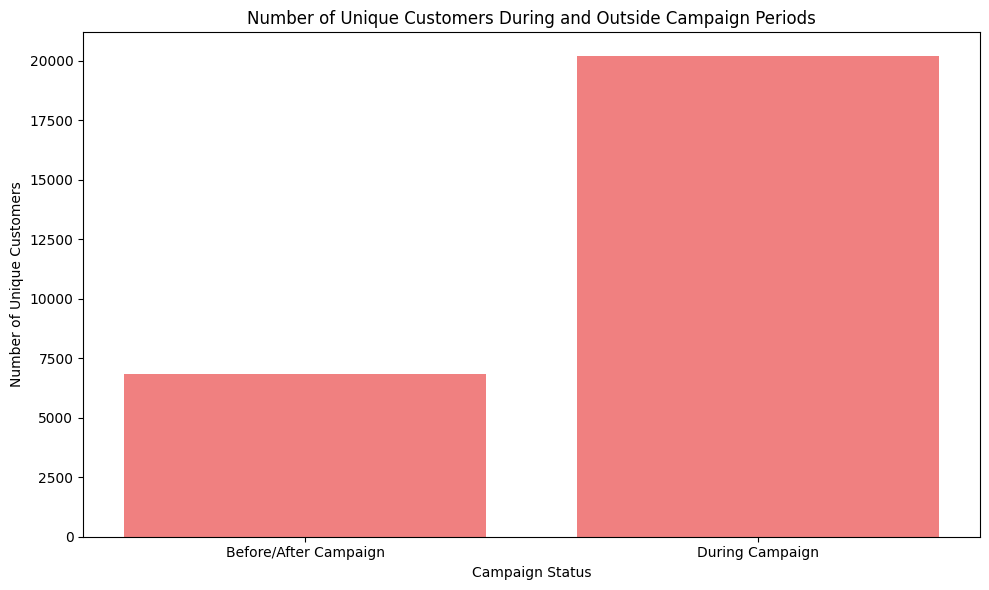

In [38]:
# 'Order Item Discount Rate'을 이용하여 할인 캠페인 효과를 분석합니다.
# 우선, 할인율이 적용된 주문과 그렇지 않은 주문을 구분합니다.

# 주문 날짜 컬럼을 날짜 형식으로 변환
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'], errors='coerce')

# 할인율이 0보다 큰 경우를 캠페인 기간으로 가정
data['Campaign'] = data['Order Item Discount Rate'] > 0

# 캠페인 기간과 비캠페인 기간의 매출 비교
campaign_effect = data.groupby('Campaign').agg(
    Total_Sales=('Sales', 'sum'),      # 총 매출
    Average_Sales=('Sales', 'mean'),   # 평균 매출
    Total_Orders=('Order Id', 'count'),# 총 주문 수
    Unique_Customers=('Customer Id', 'nunique')  # 고유 고객 수
).reset_index()

# 캠페인 여부를 표시하기 위해 값을 명확히 표시
campaign_effect['Campaign'] = campaign_effect['Campaign'].replace({True: 'During Campaign', False: 'Before/After Campaign'})

print("캠페인 기간과 비캠페인 기간의 매출 비교:")
print(campaign_effect)

# 시각화: 캠페인 기간과 비캠페인 기간의 총 매출 비교
plt.figure(figsize=(10, 6))
plt.bar(campaign_effect['Campaign'], campaign_effect['Total_Sales'], color='lightblue')
plt.xlabel('Campaign Status')
plt.ylabel('Total Sales')
plt.title('Total Sales During and Outside Campaign Periods')
plt.tight_layout()
plt.show()

# 시각화: 캠페인 기간과 비캠페인 기간의 평균 매출 비교
plt.figure(figsize=(10, 6))
plt.bar(campaign_effect['Campaign'], campaign_effect['Average_Sales'], color='lightgreen')
plt.xlabel('Campaign Status')
plt.ylabel('Average Sales per Order')
plt.title('Average Sales per Order During and Outside Campaign Periods')
plt.tight_layout()
plt.show()

# 시각화: 캠페인 기간과 비캠페인 기간의 고객 수 비교
plt.figure(figsize=(10, 6))
plt.bar(campaign_effect['Campaign'], campaign_effect['Unique_Customers'], color='lightcoral')
plt.xlabel('Campaign Status')
plt.ylabel('Number of Unique Customers')
plt.title('Number of Unique Customers During and Outside Campaign Periods')
plt.tight_layout()
plt.show()


이익률이 가장 높은 상위 10명 고객:
       Customer Id  Total_Sales  Total_Profit  Profit_Rate
12780        12886    11.290000      5.650000    50.044288
20047        20153    39.750000     19.879999    50.012577
16010        16116   260.649994    130.330002    50.001920
17275        17381   215.820007    107.910004    50.000000
17329        17435   215.820007    107.910004    50.000000
13421        13527   452.040008    226.020004    50.000000
13097        13203   452.040008    226.020004    50.000000
16915        17021    11.540000      5.770000    50.000000
14755        14861   461.480011    230.740005    50.000000
19704        19810    39.750000     19.680000    49.509435

이익률이 가장 낮은 하위 10명 고객:
       Customer Id  Total_Sales  Total_Profit  Profit_Rate
13184        13290   452.040008  -1205.819946  -266.750713
19702        19808    39.750000   -104.110001  -261.911951
13093        13199   452.040008  -1171.689941  -259.200495
17923        18029   357.100006   -925.599976  -259.199093
14980      

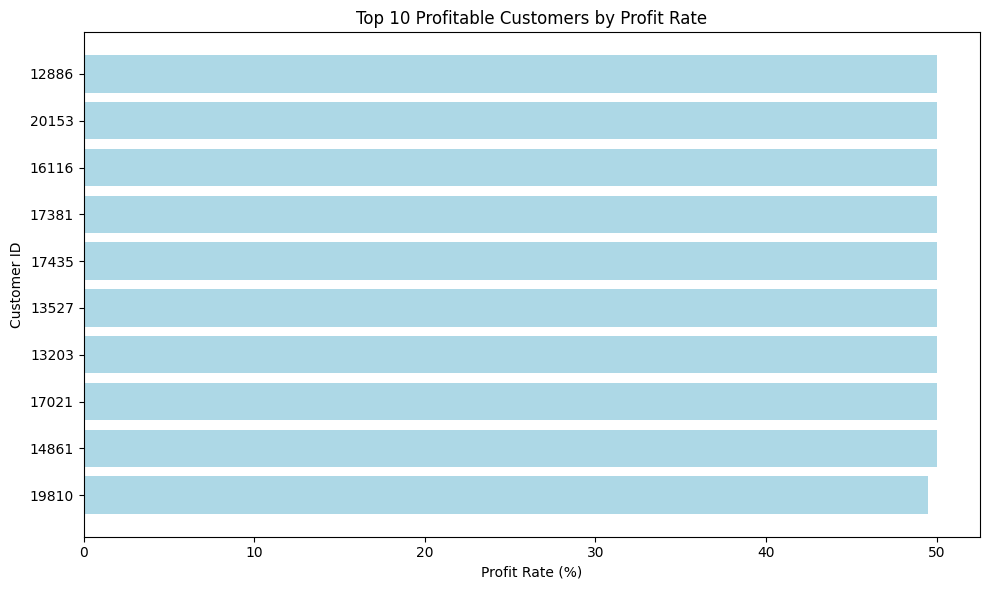

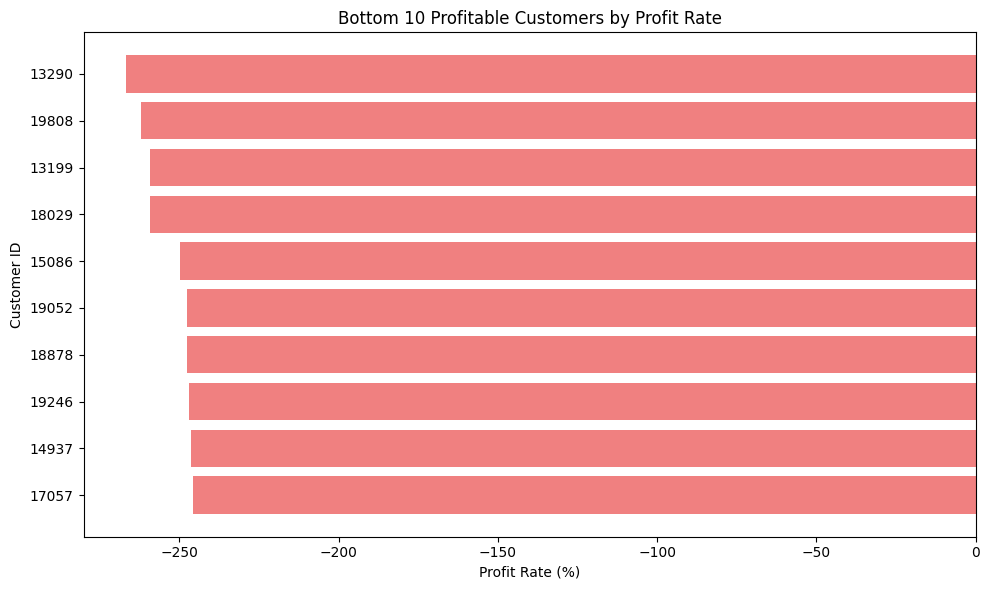

In [39]:
# 고객별 이익률을 계산하기 위해 필요한 데이터 추출
customer_profit_analysis = data.groupby('Customer Id').agg(
    Total_Sales=('Sales', 'sum'),                # 총 매출
    Total_Profit=('Order Profit Per Order', 'sum')  # 총 이익
).reset_index()

# 고객별 이익률 계산 (이익률 = 총 이익 / 총 매출)
customer_profit_analysis['Profit_Rate'] = (customer_profit_analysis['Total_Profit'] / customer_profit_analysis['Total_Sales']) * 100

# 이익률이 높은 상위 10명의 고객 확인
top_10_profitable_customers = customer_profit_analysis.sort_values(by='Profit_Rate', ascending=False).head(10)

# 이익률이 낮은 하위 10명의 고객 확인
bottom_10_profitable_customers = customer_profit_analysis.sort_values(by='Profit_Rate', ascending=True).head(10)

print("이익률이 가장 높은 상위 10명 고객:")
print(top_10_profitable_customers)

print("\n이익률이 가장 낮은 하위 10명 고객:")
print(bottom_10_profitable_customers)

# 시각화: 이익률이 높은 상위 10명 고객
plt.figure(figsize=(10, 6))
plt.barh(top_10_profitable_customers['Customer Id'].astype(str), top_10_profitable_customers['Profit_Rate'], color='lightblue')
plt.xlabel('Profit Rate (%)')
plt.ylabel('Customer ID')
plt.title('Top 10 Profitable Customers by Profit Rate')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 시각화: 이익률이 낮은 하위 10명 고객
plt.figure(figsize=(10, 6))
plt.barh(bottom_10_profitable_customers['Customer Id'].astype(str), bottom_10_profitable_customers['Profit_Rate'], color='lightcoral')
plt.xlabel('Profit Rate (%)')
plt.ylabel('Customer ID')
plt.title('Bottom 10 Profitable Customers by Profit Rate')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


고객 세그먼트별 매출 분석 결과:
  Customer Segment   Total_Sales  Average_Sales  Purchase_Frequency  \
0         Consumer  1.716428e+07     183.567317               93504   
1        Corporate  1.003065e+07     183.077806               54789   
2      Home Office  5.859474e+06     181.824431               32226   

   Unique_Customers  
0             10695  
1              6239  
2              3718  


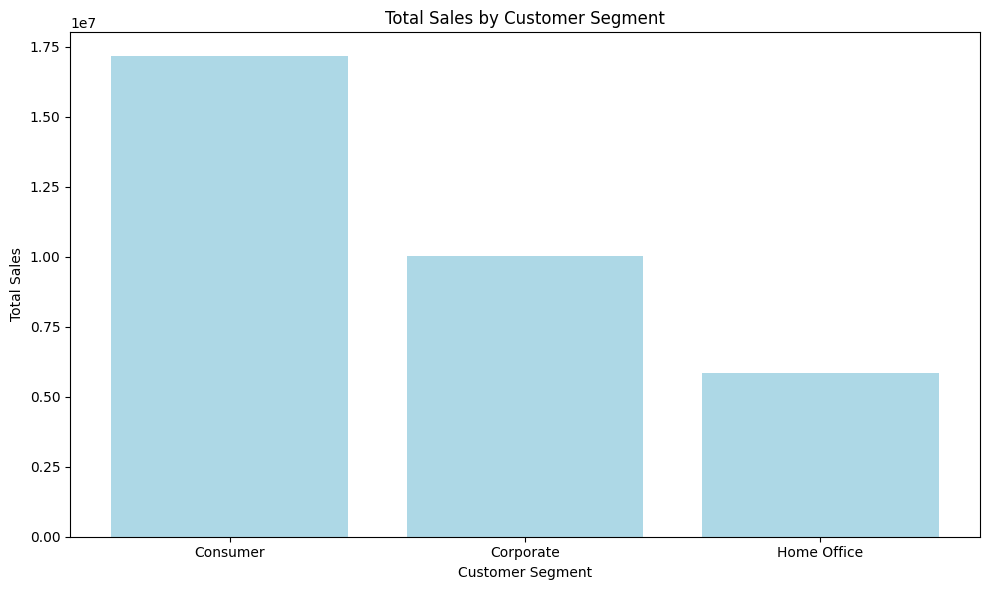

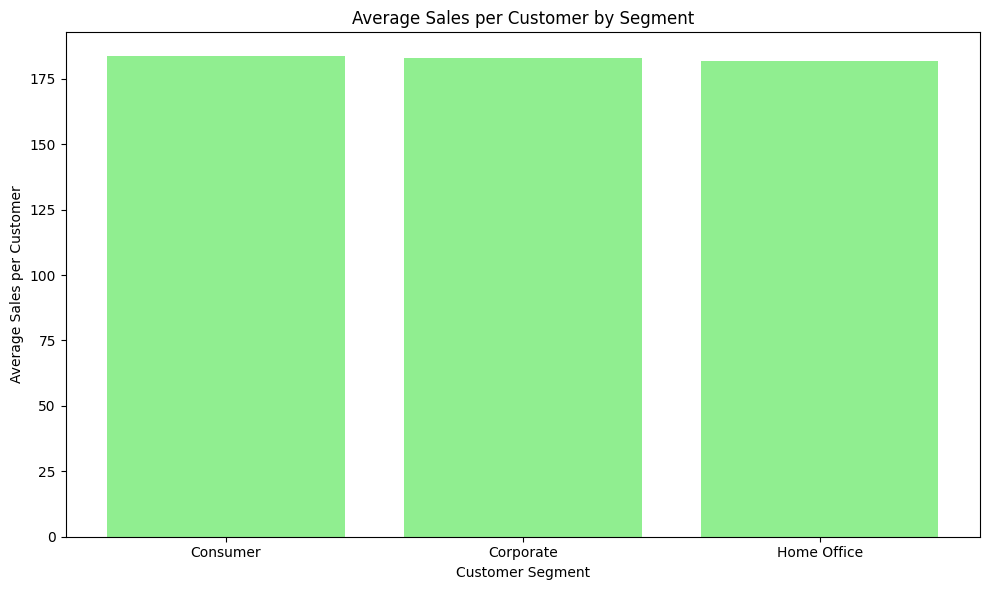

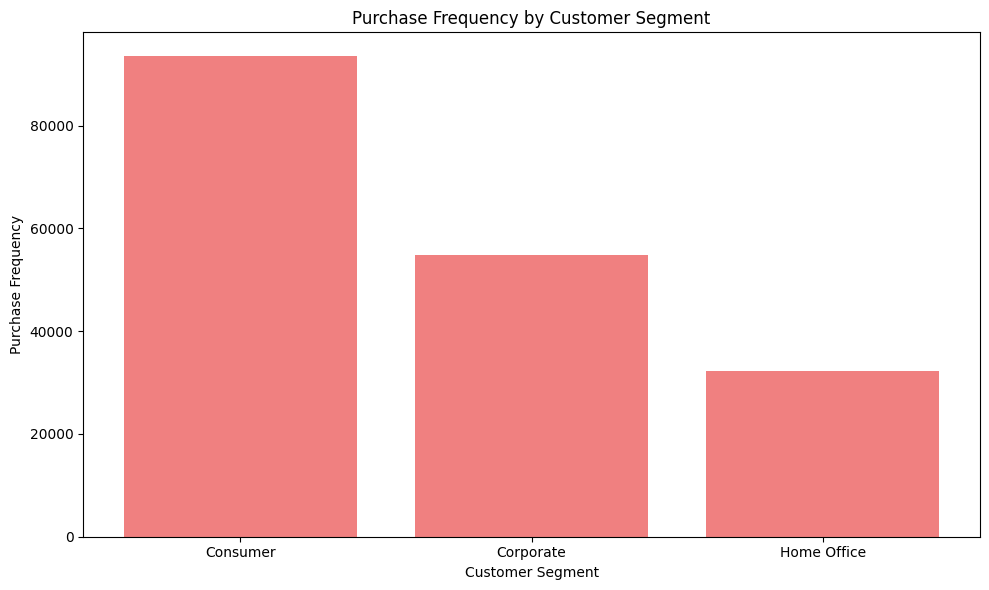

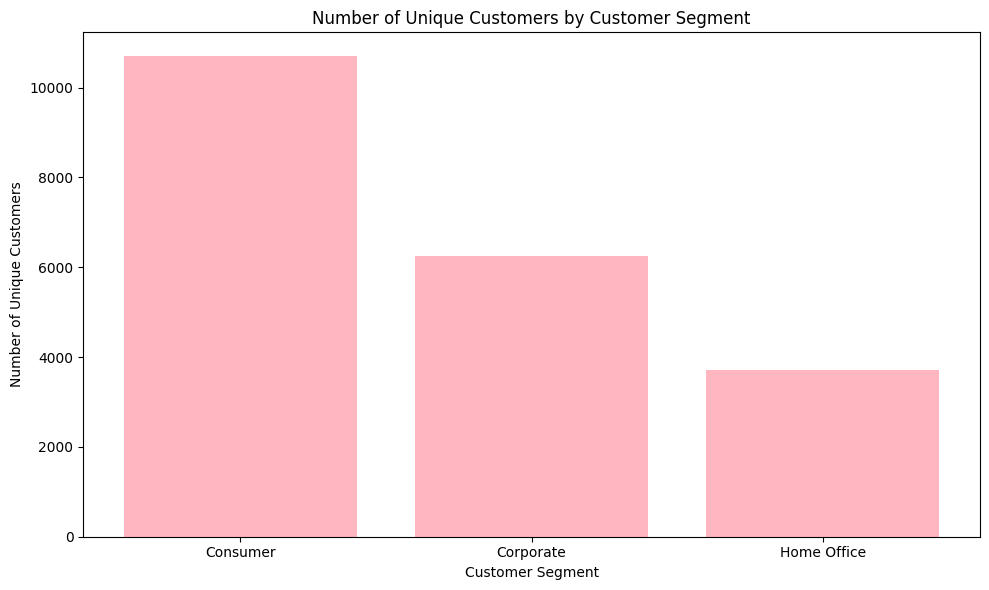

In [40]:
# 'Customer Segment' 컬럼을 사용하여 고객 세그먼트별 매출 분석을 진행합니다.
# 고객 세그먼트별로 총 매출, 평균 매출, 구매 빈도, 고유 고객 수를 집계합니다.
segment_analysis = data.groupby('Customer Segment').agg(
    Total_Sales=('Sales per customer', 'sum'),        # 총 매출
    Average_Sales=('Sales per customer', 'mean'),     # 평균 매출
    Purchase_Frequency=('Order Id', 'count'),         # 구매 빈도
    Unique_Customers=('Customer Id', 'nunique')    # 고유 고객 수
).reset_index()

# 세그먼트별 매출 분석 결과 출력
print("고객 세그먼트별 매출 분석 결과:")
print(segment_analysis)

# 시각화: 고객 세그먼트별 총 매출
plt.figure(figsize=(10, 6))
plt.bar(segment_analysis['Customer Segment'], segment_analysis['Total_Sales'], color='lightblue')
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.title('Total Sales by Customer Segment')
plt.tight_layout()
plt.show()

# 시각화: 고객 세그먼트별 평균 매출
plt.figure(figsize=(10, 6))
plt.bar(segment_analysis['Customer Segment'], segment_analysis['Average_Sales'], color='lightgreen')
plt.xlabel('Customer Segment')
plt.ylabel('Average Sales per Customer')
plt.title('Average Sales per Customer by Segment')
plt.tight_layout()
plt.show()

# 시각화: 고객 세그먼트별 구매 빈도
plt.figure(figsize=(10, 6))
plt.bar(segment_analysis['Customer Segment'], segment_analysis['Purchase_Frequency'], color='lightcoral')
plt.xlabel('Customer Segment')
plt.ylabel('Purchase Frequency')
plt.title('Purchase Frequency by Customer Segment')
plt.tight_layout()
plt.show()

# 시각화: 고객 세그먼트별 고유 고객 수
plt.figure(figsize=(10, 6))
plt.bar(segment_analysis['Customer Segment'], segment_analysis['Unique_Customers'], color='lightpink')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Unique Customers')
plt.title('Number of Unique Customers by Customer Segment')
plt.tight_layout()
plt.show()


이익률에 따른 고객 세분화 결과:
  Profit_Category  Total_Customers  Average_Profit_Rate   Total_Sales  \
0     High Profit             3531            37.619272  2.052173e+06   
1      Low Profit             3390             5.673151  7.260027e+06   
2   Medium Profit             9662            20.417149  2.035846e+07   
3    Unprofitable             4069           -30.750404  7.114079e+06   

   Total_Profit  
0  7.215513e+05  
1  4.039305e+05  
2  3.921721e+06  
3 -1.080300e+06  


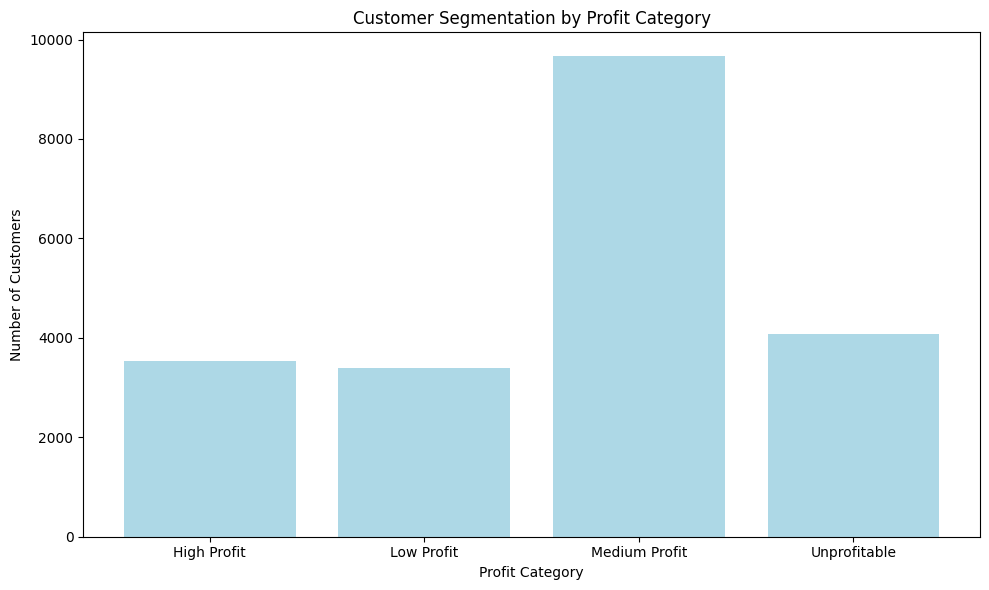

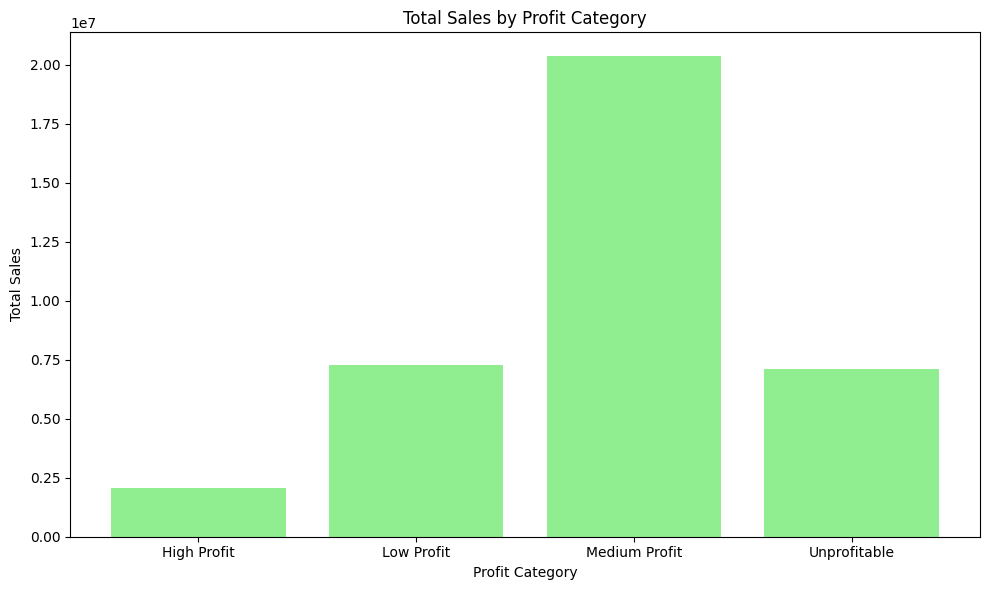

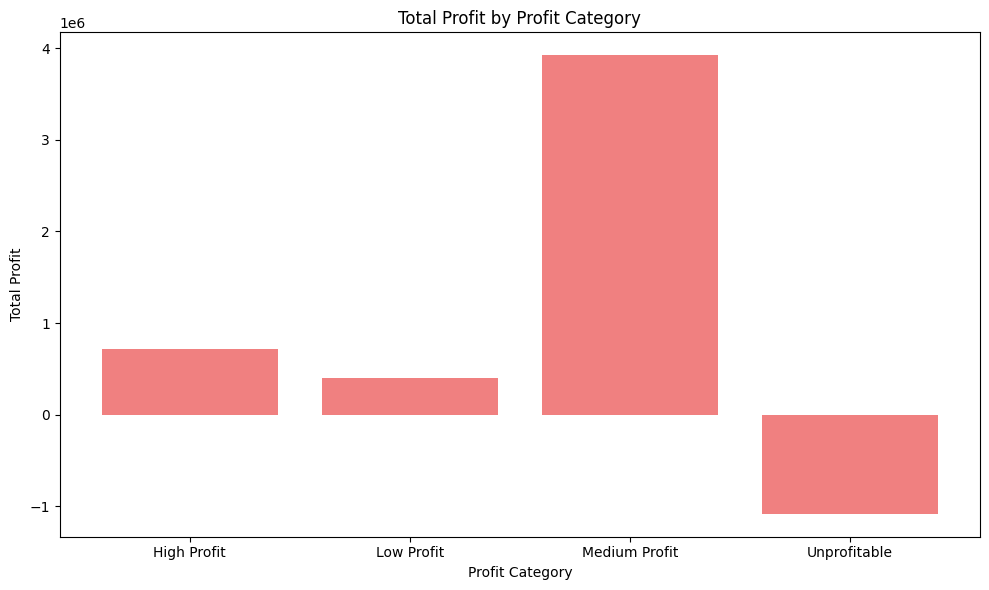

In [41]:
# 기존의 고객별 이익률 분석 데이터프레임을 사용하여 고객 세분화 기준을 적용합니다.
# 이익률에 따른 고객 세분화
def categorize_profit_rate(profit_rate):
    if profit_rate > 30:
        return 'High Profit'
    elif 10 <= profit_rate <= 30:
        return 'Medium Profit'
    elif 0 <= profit_rate < 10:
        return 'Low Profit'
    else:
        return 'Unprofitable'

# 고객 이익률 데이터프레임에 세분화된 고객 분류 추가
customer_profit_analysis['Profit_Category'] = customer_profit_analysis['Profit_Rate'].apply(categorize_profit_rate)

# 각 세분화된 고객 그룹의 분포를 확인
profit_segment_summary = customer_profit_analysis.groupby('Profit_Category').agg(
    Total_Customers=('Customer Id', 'count'),
    Average_Profit_Rate=('Profit_Rate', 'mean'),
    Total_Sales=('Total_Sales', 'sum'),
    Total_Profit=('Total_Profit', 'sum')
).reset_index()

# 세분화된 고객 그룹별 결과 출력
print("이익률에 따른 고객 세분화 결과:")
print(profit_segment_summary)

# 시각화: 이익률에 따른 고객 분류별 고객 수
plt.figure(figsize=(10, 6))
plt.bar(profit_segment_summary['Profit_Category'], profit_segment_summary['Total_Customers'], color='lightblue')
plt.xlabel('Profit Category')
plt.ylabel('Number of Customers')
plt.title('Customer Segmentation by Profit Category')
plt.tight_layout()
plt.show()

# 시각화: 이익률에 따른 고객 분류별 총 매출
plt.figure(figsize=(10, 6))
plt.bar(profit_segment_summary['Profit_Category'], profit_segment_summary['Total_Sales'], color='lightgreen')
plt.xlabel('Profit Category')
plt.ylabel('Total Sales')
plt.title('Total Sales by Profit Category')
plt.tight_layout()
plt.show()

# 시각화: 이익률에 따른 고객 분류별 총 이익
plt.figure(figsize=(10, 6))
plt.bar(profit_segment_summary['Profit_Category'], profit_segment_summary['Total_Profit'], color='lightcoral')
plt.xlabel('Profit Category')
plt.ylabel('Total Profit')
plt.title('Total Profit by Profit Category')
plt.tight_layout()
plt.show()


월별 매출 및 고객 변화 추이 분석:
    Year  Month   Total_Sales  Unique_Customers Year-Month
0   2015      1  9.453822e+05              1668     2015-1
1   2015      2  8.330124e+05              1500     2015-2
2   2015      3  9.440501e+05              1654     2015-3
3   2015      4  9.120044e+05              1596     2015-4
4   2015      5  9.439398e+05              1654     2015-5
5   2015      6  9.202421e+05              1616     2015-6
6   2015      7  9.329368e+05              1628     2015-7
7   2015      8  9.251929e+05              1650     2015-8
8   2015      9  9.145224e+05              1608     2015-9
9   2015     10  9.431311e+05              1635    2015-10
10  2015     11  9.246026e+05              1604    2015-11
11  2015     12  9.505269e+05              1685    2015-12
12  2016      1  9.402836e+05              1643     2016-1
13  2016      2  8.701167e+05              1525     2016-2
14  2016      3  9.214877e+05              1647     2016-3
15  2016      4  9.004929e+05      

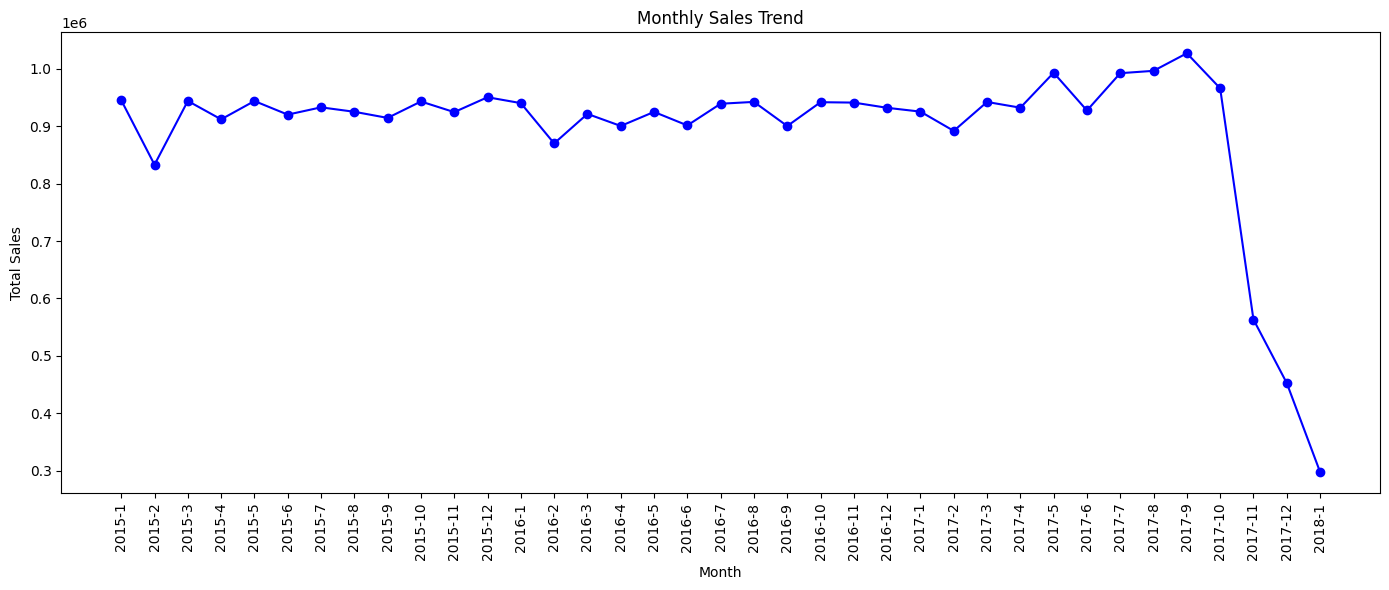

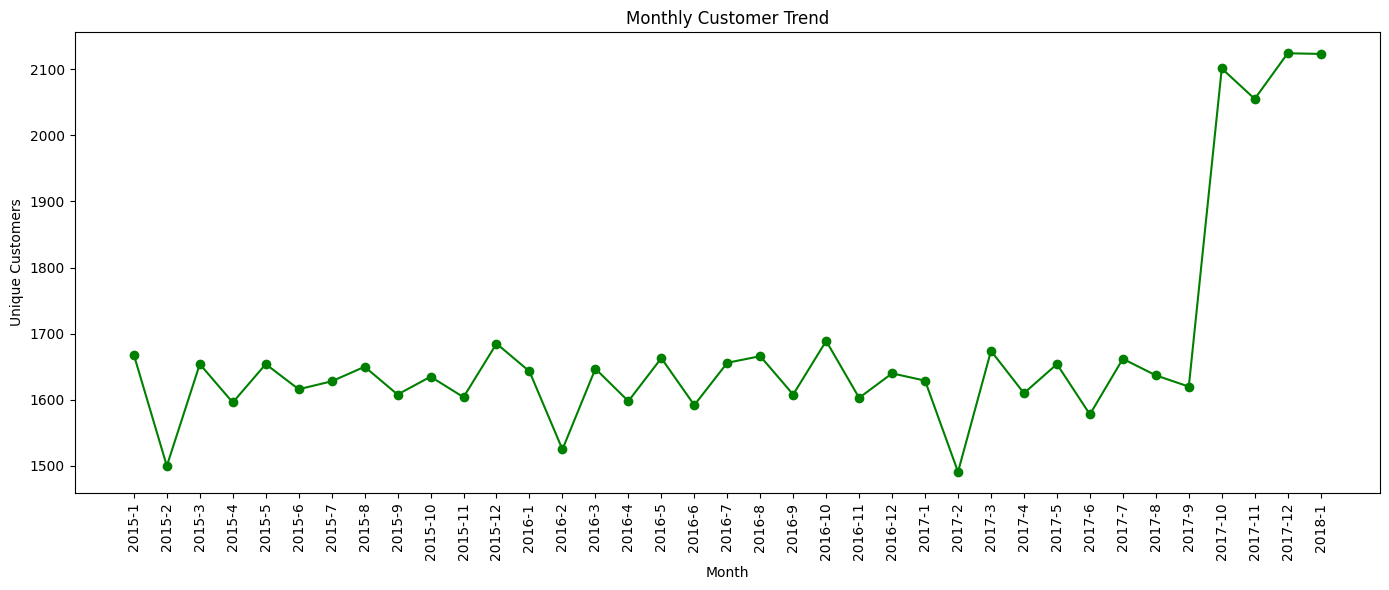

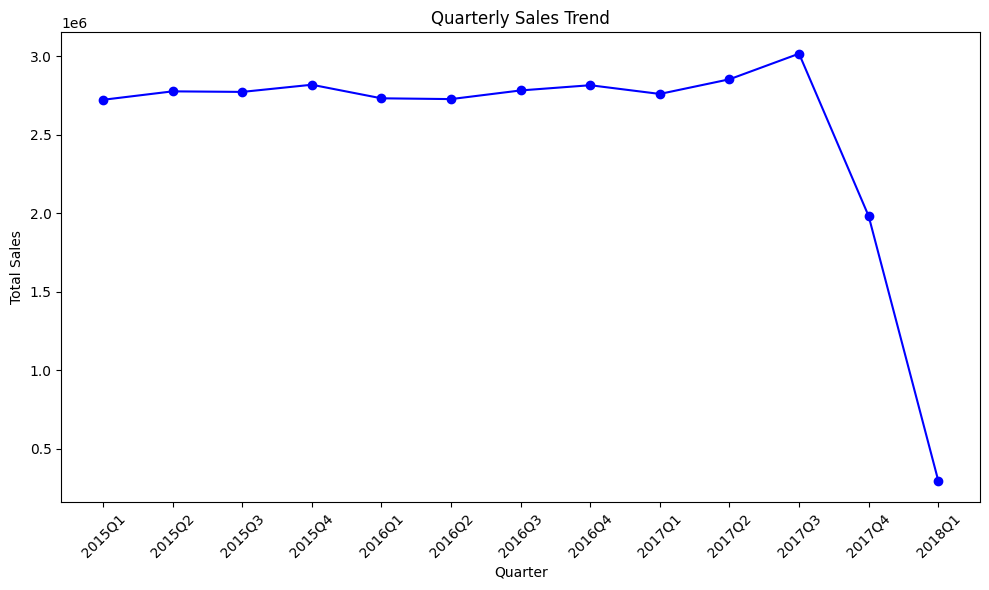

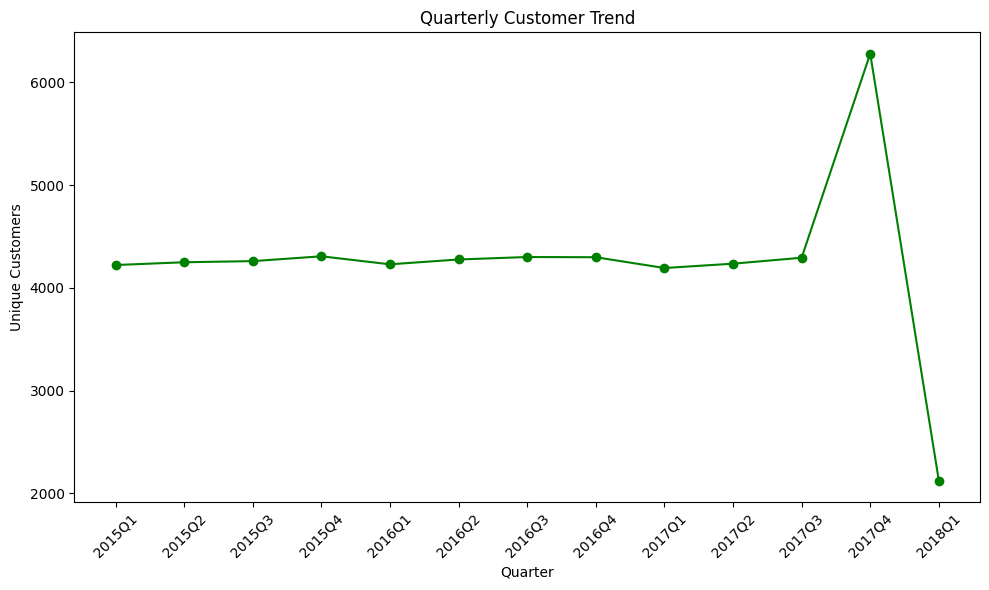

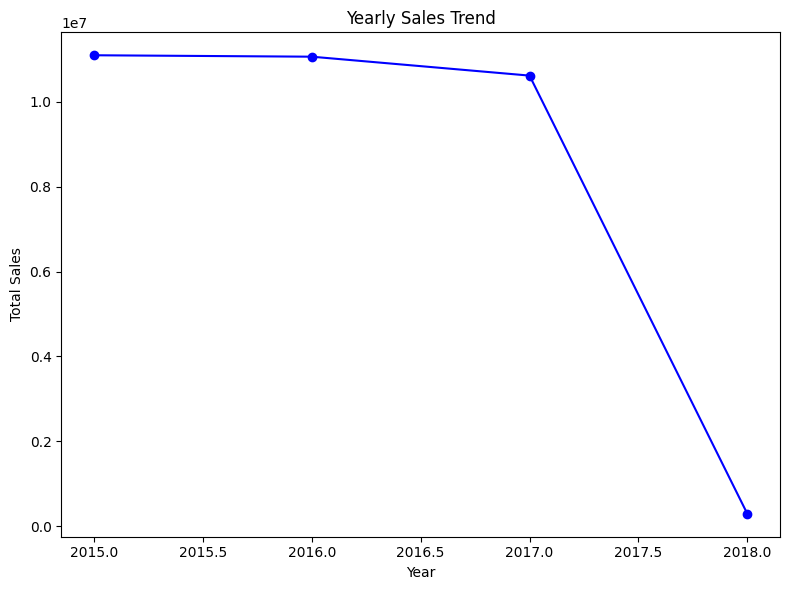

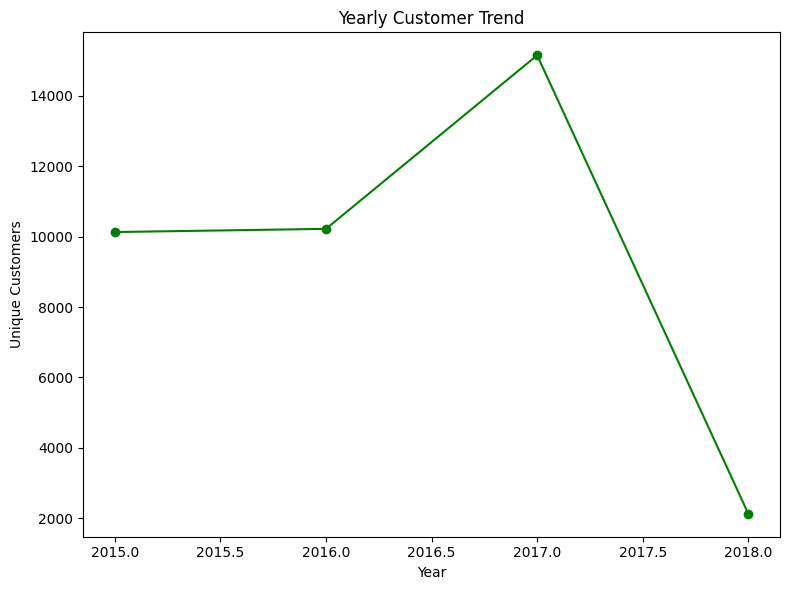

In [9]:
# 'order date (DateOrders)' 컬럼을 날짜 형식으로 변환한 후 연도, 월, 분기 추출
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'], errors='coerce')
data['Year'] = data['order date (DateOrders)'].dt.year
data['Month'] = data['order date (DateOrders)'].dt.month
data['Quarter'] = data['order date (DateOrders)'].dt.to_period('Q')

# 월별 매출 및 고객 변화 추이 분석
monthly_analysis = data.groupby(['Year', 'Month']).agg(
    Total_Sales=('Sales per customer', 'sum'),      # 총 매출
    Unique_Customers=('Customer Id', 'nunique')  # 고유 고객 수
).reset_index()

# 분기별 매출 및 고객 변화 추이 분석
quarterly_analysis = data.groupby('Quarter').agg(
    Total_Sales=('Sales per customer', 'sum'),      # 총 매출
    Unique_Customers=('Customer Id', 'nunique')  # 고유 고객 수
).reset_index()

# 연도별 매출 및 고객 변화 추이 분석
yearly_analysis = data.groupby('Year').agg(
    Total_Sales=('Sales per customer', 'sum'),      # 총 매출
    Unique_Customers=('Customer Id', 'nunique')  # 고유 고객 수
).reset_index()

# 월별 분석 데이터에서 'Year'과 'Month'를 합쳐서 x축을 생성
monthly_analysis['Year-Month'] = monthly_analysis['Year'].astype(str) + '-' + monthly_analysis['Month'].astype(str)

print("월별 매출 및 고객 변화 추이 분석:")
print(monthly_analysis)

print("분기별 매출 및 고객 변화 추이 분석:")
print(quarterly_analysis)

print("연도별 매출 및 고객 변화 추이 분석:")
print(yearly_analysis)

# 월별 매출 추이 시각화
plt.figure(figsize=(14, 6))
plt.plot(monthly_analysis['Year-Month'], monthly_analysis['Total_Sales'], marker='o', color='blue', label='Total Sales')
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trend')
plt.tight_layout()
plt.show()

# 월별 고유 고객 변화 추이 시각화
plt.figure(figsize=(14, 6))
plt.plot(monthly_analysis['Year-Month'], monthly_analysis['Unique_Customers'], marker='o', color='green', label='Unique Customers')
plt.xticks(rotation=90)
plt.xlabel('Month')
plt.ylabel('Unique Customers')
plt.title('Monthly Customer Trend')
plt.tight_layout()
plt.show()

# 분기별 매출 및 고객 변화 추이 시각화
plt.figure(figsize=(10, 6))
plt.plot(quarterly_analysis['Quarter'].astype(str), quarterly_analysis['Total_Sales'], marker='o', color='blue', label='Total Sales')
plt.xticks(rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.title('Quarterly Sales Trend')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(quarterly_analysis['Quarter'].astype(str), quarterly_analysis['Unique_Customers'], marker='o', color='green', label='Unique Customers')
plt.xticks(rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Unique Customers')
plt.title('Quarterly Customer Trend')
plt.tight_layout()
plt.show()

# 연도별 매출 및 고객 변화 추이 시각화
plt.figure(figsize=(8, 6))
plt.plot(yearly_analysis['Year'], yearly_analysis['Total_Sales'], marker='o', color='blue', label='Total Sales')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Yearly Sales Trend')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(yearly_analysis['Year'], yearly_analysis['Unique_Customers'], marker='o', color='green', label='Unique Customers')
plt.xlabel('Year')
plt.ylabel('Unique Customers')
plt.title('Yearly Customer Trend')
plt.tight_layout()
plt.show()


주중/주말 구매 패턴 분석 결과:
    Total_Sales  Purchase_Frequency  Unique_Customers   Period
0  2.345898e+07              128672             17969  Weekday
1  9.595427e+06               51847             11384  Weekend


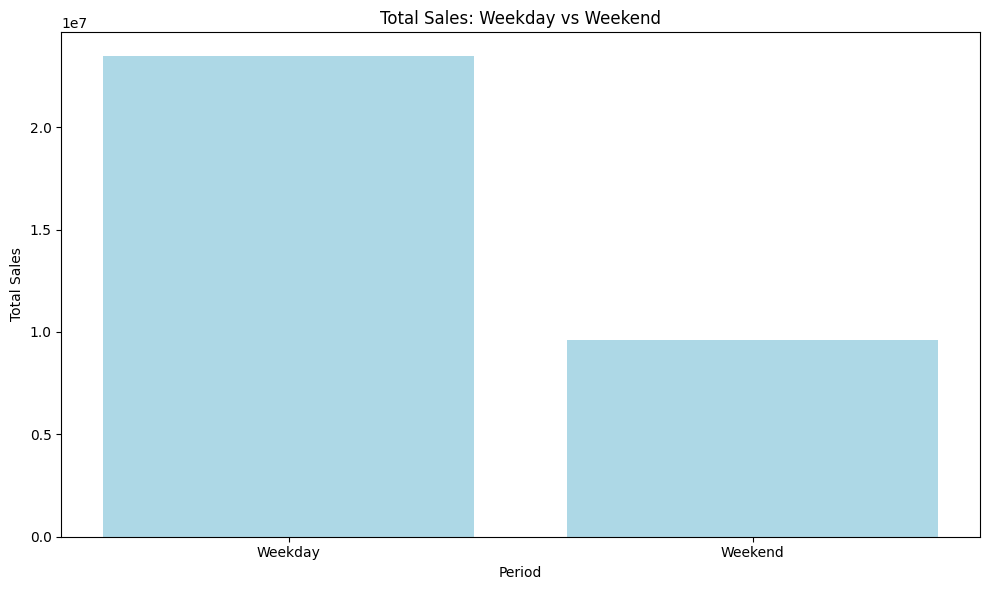

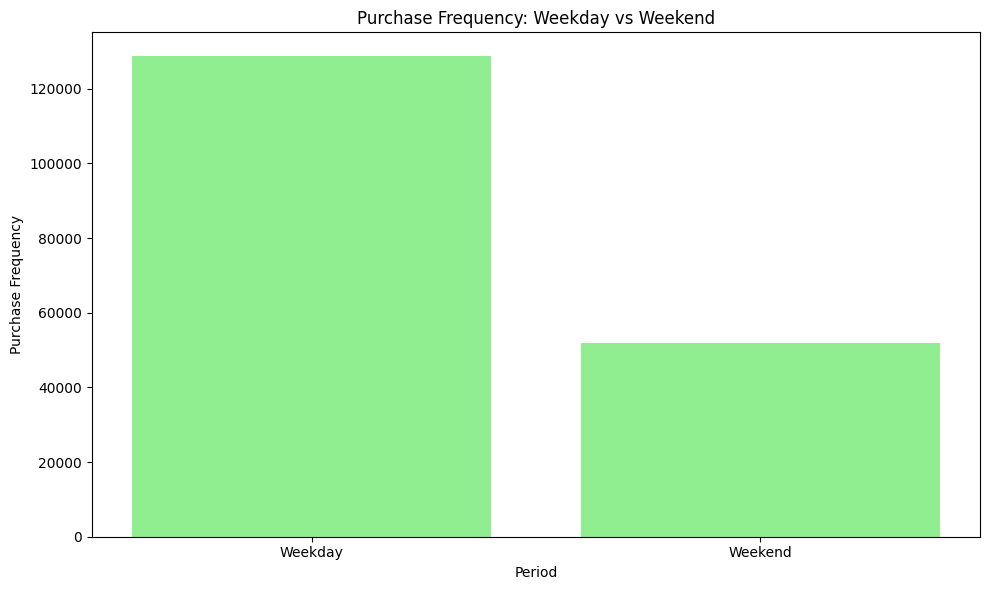

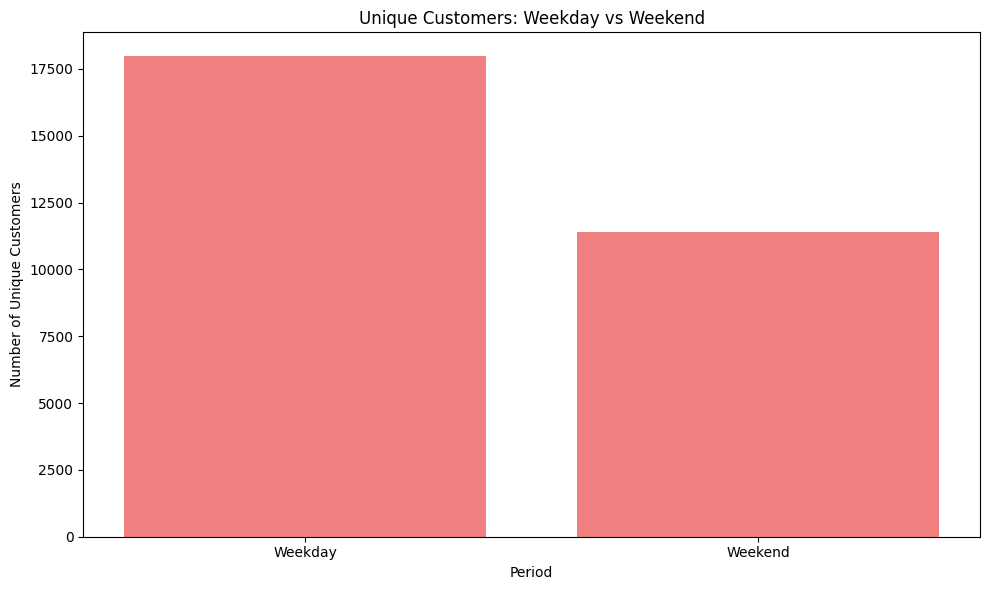

In [11]:
#주중/주말 구매 패턴
# 'order date (DateOrders)' 컬럼에서 요일을 추출하고 주중/주말을 구분합니다.
data['Weekday'] = data['order date (DateOrders)'].dt.day_name()  # 요일 이름 추출
data['Is_Weekend'] = data['Weekday'].isin(['Saturday', 'Sunday'])  # 주말 여부 (True if Saturday or Sunday)

# 주중과 주말에 발생한 총 매출, 구매 빈도, 고객 수를 집계합니다.
weekday_analysis = data.groupby('Is_Weekend').agg(
    Total_Sales=('Sales per customer', 'sum'),      # 총 매출
    Purchase_Frequency=('Order Id', 'count'),       # 구매 횟수
    Unique_Customers=('Customer Id', 'nunique')  # 고유 고객 수
).reset_index()

# 주중/주말 여부를 명확히 표시하기 위해 값을 변경
weekday_analysis['Period'] = weekday_analysis['Is_Weekend'].replace({True: 'Weekend', False: 'Weekday'})
weekday_analysis = weekday_analysis.drop(columns=['Is_Weekend'])

# 주중/주말 구매 패턴 결과 출력
print("주중/주말 구매 패턴 분석 결과:")
print(weekday_analysis)

# 시각화: 주중/주말 총 매출 비교
plt.figure(figsize=(10, 6))
plt.bar(weekday_analysis['Period'], weekday_analysis['Total_Sales'], color='lightblue')
plt.xlabel('Period')
plt.ylabel('Total Sales')
plt.title('Total Sales: Weekday vs Weekend')
plt.tight_layout()
plt.show()

# 시각화: 주중/주말 구매 빈도 비교
plt.figure(figsize=(10, 6))
plt.bar(weekday_analysis['Period'], weekday_analysis['Purchase_Frequency'], color='lightgreen')
plt.xlabel('Period')
plt.ylabel('Purchase Frequency')
plt.title('Purchase Frequency: Weekday vs Weekend')
plt.tight_layout()
plt.show()

# 시각화: 주중/주말 고유 고객 수 비교
plt.figure(figsize=(10, 6))
plt.bar(weekday_analysis['Period'], weekday_analysis['Unique_Customers'], color='lightcoral')
plt.xlabel('Period')
plt.ylabel('Number of Unique Customers')
plt.title('Unique Customers: Weekday vs Weekend')
plt.tight_layout()
plt.show()
